In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import traceback
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
def check_old_naming(animalid, session, fov, experiment='blobs', traceid='traces001',
                decode_type='single_cells', sub_dir='dff-nstds_stimulus', C_str='tuneC',
                rootdir='/n/coxfs01/2p-data'):
    
    res_files = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', decode_type, sub_dir, '*%s*.pkl' % C_str))
    for r in res_files:
        curr_dir, fname = os.path.split(r)
        if fname.startswith('single_cells_'):
            new_name = fname.split('single_cells_')[-1]
            os.rename(r, os.path.join(curr_dir, new_name))
    return


In [4]:
def plot_true_and_shuffled_distns(meandf, metric='heldout_test_score', return_scores=True, ax=None):
    '''
    Takes 
    '''
    
    tru_df = meandf[meandf['condition']=='data']
    shu_df = meandf[meandf['condition']=='shuffled']

    mean_score = tru_df[metric].mean()
    shuffled_score = shu_df[metric].mean()
    score_percentile = np.mean(mean_score < shu_df[metric])
    #print('%.2f, %.2f' % (mean_score, shuffled_score))

    # PLOT
    if ax is None:
        fig, ax = pl.subplots()
    sns.distplot(tru_df[metric], ax=ax, color='m')
    sns.distplot(shu_df[metric], ax=ax, color='k')
    ax.axvline(x=mean_score, linestyle=':', color='m')
    ax.axvline(x=shuffled_score, linestyle=':', color='k')
    
    if return_scores:
        return ax, mean_score, score_percentile
    else:
        return ax
    
    

In [5]:
def stripplot_by_area(metric, data_df, ax=None, area_colors=None, size=5,
                     visual_areas=['V1', 'Lm', 'Li', 'Ll'], scale=2, bar=True, annotate=True, xytext=(0, -10)):
    if ax is None:
        fig, ax = pl.subplots()
        
    if area_colors is None:
        cols = sns.color_palette('colorblind', n_colors=len(visual_areas))
        area_colors = dict((v, c) for v, c in zip(visual_areas, cols))    
    
    if bar or annotate:
        sns.barplot(x='visual_area',  y=metric, data=data_df, ax=ax,
                           order=visual_areas,
                           zorder=0, edgecolor='none', facecolor='none', color='none')
        data_df.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=xytext)
        
    sns.stripplot(x='visual_area',  y=metric, data=data_df, ax=ax,
               order=visual_areas, hue='visual_area',
               zorder=1, size=2, palette=area_colors)

    sns.pointplot(x='visual_area',  y=metric, data=data_df, ax=ax, join=False,
               order=visual_areas, markers='_', color='k', # palette=area_colors,
               scale=1, zorder=1000)
    
    return ax


In [25]:
def get_single_cell_files(animalid, session, fovnum, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', visual_area=None, roi_list=None, 
                               test_type=None,
                               verbose=False, rootdir='/n/coxfs01/2p-data'):
    # Get results ID (data identifier)
    result_id = dc.create_results_id(prefix='single_cells',
                            visual_area=visual_area, C_value=C_value, 
                            response_type=response_type, responsive_test=responsive_test, 
                            trial_epoch=trial_epoch, test_type=test_type)
    
    curr_datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    traceid_dir = dc.get_traceid_dir_from_datakey(curr_datakey, traceid=traceid)
    
    src_dir, save_prefix = dc.single_cell_dst_dir(traceid_dir, result_id)
        
    if src_dir is None:
        print("%s - Missing: (%s_%s_%s) %s" % (visual_area, session, animalid, fov, result_id))
        return None, None, None
        
    varea, c_str = save_prefix.split('_') #'tuneC' if C_value is None else 'C%.2f' % C_value
      
    # FInd all results files
    result_fpaths=[]
    missing_fpaths=[]
    if roi_list is None and visual_area is None:
        result_fpaths = glob.glob(os.path.join(src_dir, '*%s*.pkl' % c_str))
    else:
        if roi_list is None:
            result_fpaths =  glob.glob(os.path.join(src_dir, '%s*.pkl' % (save_prefix)))
        else:
            tmp_fns = [os.path.join(src_dir, '%s__%03d.pkl' % (save_prefix, int(rid+1))) \
                                         for rid in roi_list]
            for c in tmp_fns:
                if not os.path.exists(c):
                    missing_fpaths.append(c)
                else:
                    result_fpaths.append(c)
                    
    if verbose:
        print("(%s, %s) Found %i. Missing %i." % (session, animalid, len(result_fpaths), len(missing_fpaths)))
    
    return result_fpaths, missing_fpaths, result_id

    
            
def load_cell_results_from_fov(animalid, session, fovnum, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', visual_area=None, roi_list=None,
                               test_type=None,
                               rootdir='/n/coxfs01/2p-data', verbose=False):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    missing_rois=None
    result_id=None
    
    result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fovnum, experiment, traceid=traceid,
                               C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                               trial_epoch=trial_epoch, visual_area=visual_area, 
                                roi_list=roi_list, verbose=verbose, test_type=test_type)
    
    if result_fns is None:
        return None, None, None
    
    if roi_list is not None:
        missing_rois = [int(os.path.splitext(os.path.split(f)[-1])[0].split('_')[-1])-1 for f in missing_fns]
        
    rlist=[]
    for c in result_fns:
        with open(c, 'rb') as f:
            res = pkl.load(f)
        res['iteration'] = res.index.tolist()
        res = res.reset_index(drop=True).sort_values(by='iteration')
        rlist.append(res)
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=0).reset_index(drop=True)
    
#     if (roi_list is not None) and (roidf is not None):
#         missing_rois = [r for r in roi_list if r not in roidf['cell'].unique()]
        
    return roidf, missing_rois, result_id


In [38]:
animalid = 'JC084'
session='20190522'
fovnum = 1

datakey='%s_%s_fov%i' % (session, animalid, fovnum)
visual_area='V1'

g = CELLS[(CELLS.visual_area==visual_area) & (CELLS.datakey==datakey)]
result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fovnum, experiment, traceid=traceid,
                               C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                               trial_epoch=trial_epoch, visual_area=visual_area, 
                                roi_list=g['cell'].unique(), verbose=False, test_type=test_type)
    

In [39]:
len(result_fns)

52

In [41]:
len(missing_fns)

55

In [42]:
g.shape

(107, 9)

# Dataset info

In [7]:
analysis_type='single_cells'
n_iterations=100

overlap_thr=None #0.5
n_processes=1
responsive_test='ROC'
experiment='blobs'
C_value=None

has_rfs = overlap_thr is not None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set responsivitiy params
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = 10.0 if responsive_test=='nstds' else 0.05 #float(opts.responsive_thr) #10
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

# Create data ID for labeling figures with data-types
stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'
filter_str = 'filter_%s_%s' % (stim_filterby, g_str)
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, filter_str, response_str])
print(data_id)


# Choose what type classifier to make
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr is None else float(opts.overlap_thr) 


# Set classifier training params
C_value = opts.C_value
do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))


print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")


traces001|filter_None_blobsonly|dff_ROC-thr-0.05
Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None
............................................
Responsive test: ROC (thr=0.05)
............................................


In [8]:
train_str = 'by_singlecells_iter-%i' % (n_iterations)

# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)

dpi = putils.set_plot_params()

# Output dir

In [9]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', 'single_cells')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells


# Get metadata for experiment type

In [10]:
#### Get metadata for experiment type
sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)

# sdata_exp = sdata[sdata['experiment']==experiment]
#sdata_exp['visual_area'].unique()

edata, expmeta = aggr.experiment_datakeys(experiment='blobs', has_rfs=has_rfs, 
                            has_gratings=has_gratings, stim_filterby=None,
                                experiment_only=False)
print(edata['visual_area'].unique())

Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
[u'V1' u'Ll' u'Lm' u'Li']


In [11]:
#### Load neural responses
responsive_test='ROC' #'roc'
responsive_thr=10.0 if responsive_test=='nstds' else 0.05
trial_epoch= 'plushalf' #'stimulus'
response_type='dff'

print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

#### Check for equal trial counts
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment, equalize_now=True, 
                                       response_type=response_type,
                                       responsive_test=responsive_test, 
                                       responsive_thr=responsive_thr, 
                                       trial_epoch=trial_epoch, check_configs=True, 
                                       zscore_now=True, return_configs=True, images_only=False) 
visual_areas = ['V1', 'Lm', 'Li'] #, 'Ll']
all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
sdf_master = aggr.get_master_sdf(images_only=True)

all_cells.groupby(['visual_area']).count()


............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
---equalizing now---
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


,cell,fov,animalid,session,datakey,fovnum,global_ix
visual_area,,,,,,,
Li,585,585,585,585,585,585,585
Lm,1127,1127,1127,1127,1127,1127,1127
V1,1251,1251,1251,1251,1251,1251,1251


In [12]:
overlap_thr=None
has_retino=False

has_rfs = (has_retino is False) and (overlap_thr is not None)
print('retino:', has_retino, 'rfs:', has_rfs)

match_distns = False
match_str = 'match-Li-distn' if match_distns else ''
stack_neuraldf = analysis_type=='by_ncells'

##### Get global cells
remove_too_few=False
min_ncells=5

NEURALDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                                stack_neuraldf=True, overlap_thr=overlap_thr, has_retino=has_retino, 
                                threshold_snr=False, remove_too_few=remove_too_few) 
                                
print("------------------------------------")
print("Final cell counts:")
print(CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())


('retino:', False, 'rfs:', False)
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
             datakey  cell
visual_area               
Li               585   585
Lm              1127  1127
V1              1251  1251


In [13]:
# '20190314_JC070_fov1' in MEANS.keys()

In [18]:
#### Setup output dirs
threshold_dff=False

results_prefix = analysis_type #set_results_prefix(analysis_type=analysis_type)
if threshold_dff:
    overlap_str='threshdff'
else:
    if has_retino:
        overlap_str = 'retino'
    else:
        overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr

        
test_type='size_subset'
results_id = dc.create_results_id(prefix=results_prefix,
                        visual_area=None, C_value=C_value, trial_epoch=trial_epoch, 
                        response_type=response_type, responsive_test=responsive_test,
                        overlap_thr=overlap_thr, has_retino=has_retino, threshold_dff=threshold_dff,
                        test_type=test_type)

print(results_id)

single_cells_None__dff-ROC_noRF__plushalf__tuneC__size_subset


In [15]:
# rootdir='/n/coxfs01/2p-data'
# single_dirs = glob.glob(os.path.join(rootdir, 'JC*', '201*', 'FOV*', '*blobs*', 'traces', '%s*' % traceid, \
#                        'decoding', 'single_cells', 'dff-*_*'))

In [19]:
# import shutil

In [20]:
# #fn = single_dirs[0]

# for fn in single_dirs:
#     try:
#         bdir, bname = os.path.split(fn)
#         resp_str, tepoch = bname.split('_')
#         rtype, rtest = resp_str.split('-')

#         newname = '%s_%s' % (rtype, tepoch)
#         #print(newname)
#         os.rename(fn, os.path.join(bdir, newname))
#     except ValueError:
#         print(fn)
#         continue

In [21]:
# oname = '/n/coxfs01/2p-data/JC061/20190306/FOV3_zoom2p0x/combined_blobs_static/traces/traces001_6db49f_traces001_145754_traces001_5a93b0_traces001_aa57db_traces001_e22b8f_traces001_9a1046/decoding/single_cells/dff-nstds_no-rfs_stimulus'
# nname = '/n/coxfs01/2p-data/JC061/20190306/FOV3_zoom2p0x/combined_blobs_static/traces/traces001_6db49f_traces001_145754_traces001_5a93b0_traces001_aa57db_traces001_e22b8f_traces001_9a1046/decoding/single_cells/dff-nstds_noRFs_stimulus'

# os.listdir(oname)



# Decode

In [16]:
test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


In [ ]:
# Load single_cells pass

In [ ]:
percentiles = dc.load_single_cells_pass(responsive_test=responsive_test)
percentiles.groupby(['visual_area']).count()['cell']

In [ ]:
p_thr=0.1
# Filter
#excl=['20190314_JC070_fov1', '20190327_JC073_fov1'] if analysis_type=='by_ncells' else []
excl=[]
pass_single = score_percentiles[(percentiles['percentile']<=p_thr)
                               & ~(percentiles['datakey'].isin(excl))].copy()
pass_single['mean_score'] = pass_single['mean_score'].astype(float)
pass_single.groupby(['visual_area']).count()['cell']

In [19]:
trial_epoch

'plushalf'

# Aggregate all single cell results

In [43]:
missing_files = dict((k, dict()) for k in visual_areas)
r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g \
        in CELLS.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
        
    cell_lut={}
    roidf=None; missing=None; tmpid=None;
    try: 
        roidf, missing, tmpid = load_cell_results_from_fov(animalid, session, 
                             fovnum, experiment, C_value=C_value, trial_epoch=trial_epoch,
                             response_type=response_type, responsive_test=responsive_test,
                             visual_area=visual_area, roi_list=g['cell'].values, verbose=False,test_type=test_type)
    except Exception as e:
        print("ERROR: %s, %s" %(visual_area, datakey))
        traceback.print_exc()
        
        
    if missing is not None and len(missing)>0:
        missing_files[visual_area][datakey] = np.array(missing)
        
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
        
    if len(g['cell'].unique()) != len(roidf['cell'].unique()):
        print('Unequal (%s, %s)' % (visual_area, datakey))

    if 'global_ix' in g.columns:
        cell_lut = dict((k,v) for k, v in zip(g['cell'].values, g['global_ix'].values))
        roidf['global_ix'] = [cell_lut[c] for c in roidf['cell'].values]
    else:
        print("(%s, %s) - no global" % (visual_area, datakey))

    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)

singledf = pd.concat(r_list, axis=0)

[Li] 20190319_JC067_fov1 - No cells.
[Li] 20190320_JC067_fov1 - No cells.
[Li] 20190314_JC070_fov1 - No cells.
[Li] 20190315_JC070_fov1 - No cells.
[Li] 20190316_JC070_fov1 - No cells.
[Li] 20190321_JC070_fov1 - No cells.
[Li] 20190322_JC073_fov1 - No cells.
[Li] 20190327_JC073_fov1 - No cells.
[Li] 20190422_JC076_fov1 - No cells.
[Li] 20190602_JC091_fov1 - No cells.
[Li] 20190606_JC091_fov1 - No cells.
[Li] 20190607_JC091_fov1 - No cells.
[Li] 20190614_JC091_fov1 - No cells.
[Li] 20190609_JC099_fov1 - No cells.
[Li] 20190612_JC099_fov1 - No cells.
[Li] 20190617_JC099_fov1 - No cells.
[Li] 20191018_JC113_fov1 - No cells.
[Li] 20191111_JC120_fov1 - No cells.
[Lm] 20190306_JC061_fov3 - No cells.
[Lm] 20190322_JC073_fov1 - No cells.
[Lm] 20190327_JC073_fov1 - No cells.
[Lm] 20190422_JC076_fov1 - No cells.
[Lm] 20190430_JC078_fov1 - No cells.
[Lm] 20190504_JC078_fov1 - No cells.
[Lm] 20190509_JC078_fov1 - No cells.
[Lm] 20190513_JC078_fov1 - No cells.
[Lm] 20190506_JC080_fov1 - No cells.
[

In [47]:
singledf.groupby(['condition', 'train_transform', 'test_transform']).mean()

C  heldout_MI  heldout_aMI  \
condition train_transform test_transform                                       
data      10_20_30_40     50.0            17.383510    0.017697     0.013083   
                          10_20_30_40     17.383510    0.027009     0.023663   
          10_20_30_50     40.0             9.849520    0.056555     0.069975   
                          10_20_30_50      9.849520    0.023208     0.018091   
          10_20_40_50     30.0             2.753020    0.043312     0.050659   
                          10_20_40_50      2.753020    0.026398     0.022828   
          10_30_40_50     20.0             7.947100    0.039858     0.045666   
                          10_30_40_50      7.947100    0.022729     0.017405   
          20_30_40_50     10.0            13.467070    0.013522     0.007194   
                          20_30_40_50     13.467070    0.042425     0.046332   
shuffled  10_20_30_40     10_20_30_40      6.597505    0.010256    -0.001844   
          10_20_30_50     10_20_30_50      6.872995    0.009593    -0.002648   
          10_20_40_50     10_20_40_50      1.097110    0.010716    -0.001056   
          10_30_40_50     10_30_40_50     11.587060    0.010752    -0.000934   
          20_30_40_50     20_30_40_50     15.850405    0.013024     0.002377   

                                          heldout_log2MI  heldout_test_score  \
condition train_transform test_transform                                       
data      10_20_30_40     50.0                  0.025531            0.577750   
                          10_20_30_40           0.038965            0.585208   
          10_20_30_50     40.0                  0.081591            0.629083   
                          10_20_30_50           0.033482            0.579167   
          10_20_40_50     30.0                  0.062486            0.611667   
                          10_20_40_50           0.038085            0.580208   
          10_30_40_50     20.0                  0.057502            0.630167   
                          10_30_40_50           0.032791            0.576875   
          20_30_40_50     10.0                  0.019509            0.486000   
                          20_30_40_50           0.061207            0.621458   
shuffled  10_20_30_40     10_20_30_40           0.014796            0.498646   
          10_20_30_50     10_20_30_50           0.013840            0.493750   
          10_20_40_50     10_20_40_50           0.015460            0.500729   
          10_30_40_50     10_30_40_50           0.015512            0.503125   
          20_30_40_50     20_30_40_50           0.018789            0.501979   

                                          n_samples_0  n_samples_106  \
condition train_transform test_transform                               
data      10_20_30_40     50.0                   30.0           30.0   
                          10_20_30_40           120.0          120.0   
          10_20_30_50     40.0                   30.0           30.0   
                          10_20_30_50           120.0          120.0   
          10_20_40_50     30.0                   30.0           30.0   
                          10_20_40_50           120.0          120.0   
          10_30_40_50     20.0                   30.0           30.0   
                          10_30_40_50           120.0          120.0   
          20_30_40_50     10.0                   30.0           30.0   
                          20_30_40_50           120.0          120.0   
shuffled  10_20_30_40     10_20_30_40           120.0          120.0   
          10_20_30_50     10_20_30_50           120.0          120.0   
          10_20_40_50     10_20_40_50           120.0          120.0   
          10_30_40_50     10_30_40_50           120.0          120.0   
          20_30_40_50     20_30_40_50           120.0          120.0   

                                          n_trials  novel     randi  \
condition train_transform test_t

In [54]:
singledf['cell'].unique()

array([1, 5])

<IPython.core.display.Javascript object>


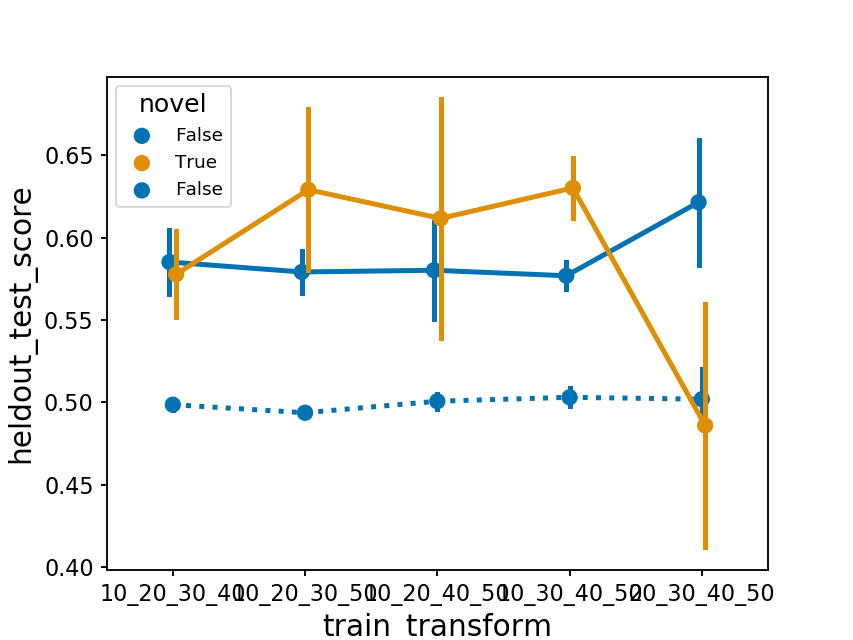

In [53]:
mdf = singledf.groupby(['cell', 'condition', 'train_transform', 'test_transform']).mean().reset_index()

fig, ax = pl.subplots()
sns.pointplot(x='train_transform', y='heldout_test_score', data=mdf[mdf.condition=='data'], ax=ax,
             hue='novel', palette='colorblind', dodge=True)
sns.pointplot(x='train_transform', y='heldout_test_score', data=mdf[mdf.condition=='shuffled'], ax=ax,
             hue='novel', palette='colorblind', dodge=True, linestyles=':')


In [37]:

# curr_datakey = '20190319_JC067_fov1'
# curr_visual_area='Li'
# session, animalid, fovnum = putils.split_datakey_str(curr_datakey)

# results_id = dc.create_results_id(prefix='single_cells',
#                         visual_area=curr_visual_area, C_value=C_value, has_retino=has_retino,
#                         response_type=response_type, responsive_test=responsive_test,
#                         overlap_thr=overlap_thr, trial_epoch=trial_epoch, threshold_dff=threshold_dff)
# print(results_id)

# traceid_dir = dc.get_traceid_dir_from_datakey(curr_datakey, traceid=traceid)
# curr_dst_dir, save_prefix = dc.single_cell_dst_dir(traceid_dir, results_id)
# save_prefix


# # old_files = glob.glob(os.path.join(curr_dst_dir, '%s_*.pkl' % save_prefix))
# curr_dst_dir, save_prefix

# gdf = CELLS[(CELLS.visual_area==curr_visual_area) & (CELLS.datakey==curr_datakey)].copy()
# roi_list = gdf['cell'].values
# len(roi_list)


'Li_tuneC'

In [155]:
# fov = 'FOV%i_zoom2p0x' % fovnum
# roi_list = g['cell'].values
# verbose=True
# result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fovnum, experiment, traceid=traceid,
#                            C_value=C_value, response_type=response_type, responsive_test=responsive_test,
#                            trial_epoch=trial_epoch, visual_area=visual_area, roi_list=roi_list, verbose=verbose)


In [156]:
# tmp_id = dc.create_results_id(prefix='single_cells',
#                         visual_area=visual_area, C_value=C_value, 
#                         response_type=response_type, responsive_test=responsive_test, 
#                         trial_epoch=trial_epoch)
# #print(results_id)

# curr_datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
# traceid_dir = dc.get_traceid_dir_from_datakey(curr_datakey, traceid=traceid)

# src_dir, save_prefix = dc.single_cell_dst_dir(traceid_dir, tmp_id)

# src_dir

In [111]:
# pp.pprint(dict((k, v.keys()) for k, v in missing_files.items()))
for v, vdict in missing_files.items():
    for d, dlist in vdict.items():
        print('[%s] %s (missing %i)' % (v, d, len(dlist)))

In [112]:
len(CELLS[CELLS.datakey=='20190315_JC070_fov1']['cell'].unique())


27

In [81]:
MEANS['20190315_JC070_fov1'].shape

(1350, 40)

In [108]:
# Average bootstrap iterations together
meandf = singledf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

# Get counts
counts_by_fov = meandf[['visual_area', 'datakey', 'cell', 'global_ix']].drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov.groupby(['visual_area']).sum()

,cell,global_ix
visual_area,,
Li,562,562
Lm,1105,1105
V1,1251,1251


In [83]:
# stat_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats'
# for r in 
# glob.glob(os.path.join(stat_dir, 'aggr_blobs_*_ROC*'))

## Filter cells that don't pass 

In [84]:
# def get_percentile_shuffled(iterdf, metric='heldout_test_score'):
#     # p_thr=0.05
#     excl_cols = ['fit_time', 'iteration', 'n_cells',  'randi', 'score_time']
#     incl_cols = [c for c in iterdf.columns if c not in excl_cols]

#     # Use bootstrap distn to calculate percentiles
#     s_=[]
#     for (visual_area, datakey, rid), d_ in iterdf.groupby(['visual_area', 'datakey', 'cell']):

#         mean_score = d_[d_['condition']=='data'][metric].mean()
#         percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
#         n_iterations = d_[d_['condition']=='data'].shape[0]
#         rdict = dict(d_[d_['condition']=='data'][incl_cols].mean())
#         rdict.update({'visual_area': visual_area, 'datakey': datakey, 'cell': rid, 
#                        'mean_score': mean_score, 'percentile': percentile, 'n_iterations': n_iterations})
#         s = pd.Series(rdict)
#         s_.append(s)
        
#     scores_by_cell = pd.concat(s_, axis=1).T.reset_index(drop=True)
    
#     return scores_by_cell


In [85]:
metric = 'heldout_test_score'
scores_by_cell = decutils.get_percentile_shuffled(singledf, metric=metric)


# Save single cells results that pass

In [86]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells'

In [87]:
print(overlap_str)

noRF


In [109]:
tmp_out = os.path.join(dst_dir, 'single_cells_percentiles_%s.pkl' % responsive_test)# % overlap_str)
with open(tmp_out, 'wb') as f:
    pkl.dump(scores_by_cell, f, protocol=pkl.HIGHEST_PROTOCOL)
    
print(tmp_out)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells/single_cells_percentiles_ROC.pkl


In [89]:
p_thr=0.05

metric='heldout_test_score'
use_percentile = False
filter_pass = True

percentiles = decutils.get_percentile_shuffled(singledf)
pass_perc = percentiles[percentiles.percentile<=p_thr].copy() #[['visual_area', 'datakey']].copy()
pass_keys = [(k, v, c) for k, v, c in pass_perc[['visual_area', 'datakey', 'cell']].values]

pass_str=''
if filter_pass:
    pass_str = '_pass_percentile' if use_percentile else '_pass'
    if use_percentile:
        passdf = pd.concat([g for 8(v, k, c), g in meandf.groupby(['visual_area', 'datakey', 'cell']) \
                    if (v, k, c) in pass_keys]).reset_index(drop=True)
    else:
        passdf = pd.concat([g for (v, k, c), g in meandf.groupby(['visual_area', 'datakey', 'cell']) \
                    if float(g[g['condition']=='shuffled'][metric]) \
                    < float(g[g['condition']=='data'][metric])]).reset_index(drop=True)
        
    print(passdf.groupby(['condition', 'visual_area'])[metric].mean())
    print(passdf.shape, meandf.shape)
else:
    passdf = itermean.copy()


ncells_pass = passdf.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]
ncells_pass

condition  visual_area
data       Li             0.540917
           Lm             0.538941
           V1             0.556395
shuffled   Li             0.499115
           Lm             0.499558
           V1             0.499159
Name: heldout_test_score, dtype: float64
((4192, 18), (5836, 18))


,visual_area,cell
0,Li,750
1,Lm,1474
2,V1,1968


In [127]:
# above_chance = False
# filter_str = 'abovechance%.2f' % p_thr if above_chance else 'nocutoff'

# if above_chance:
#     df = pd.concat([itermean[(itermean['visual_area']==visual_area) & (itermean['datakey']==datakey) \
#                            & (itermean['cell']).isin(g['cell'].unique())] for (visual_area, datakey), g in \
#                     pass_scores.groupby(['visual_area', 'datakey'])], axis=0).reset_index(drop=True)
#     ncells_pass = pass_scores.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]
# else:
#     df = itermean.copy()
#     ncells_pass = itermean[itermean['condition']=='data'].groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]

# print(filter_str)    
# print(ncells_pass)

In [90]:

pass_datakeys = [(v, k, c) for v, k, c in passdf[['visual_area', 'datakey', 'cell']]\
                     .drop_duplicates().values]

all_datakeys = [(v, k, c) for v, k, c in meandf[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().values]

print("%i of %i datasets pass" % (len(pass_datakeys), len(all_datakeys)))

dropped_ = [k for k in all_datakeys if k not in pass_datakeys]
# for k in dropped_:
#     print(k)


2096 of 2918 datasets pass


In [130]:
# pass_global = pass_scores[pass_scores['visual_area']=='V1'].copy()
# pass_global['global_cell_id'] = np.arange(0, len(pass_global))
# pass_global.sample(24).mean()


  visual_area  cell
0          Li    47
1          Lm    97
2          V1   251


<IPython.core.display.Javascript object>


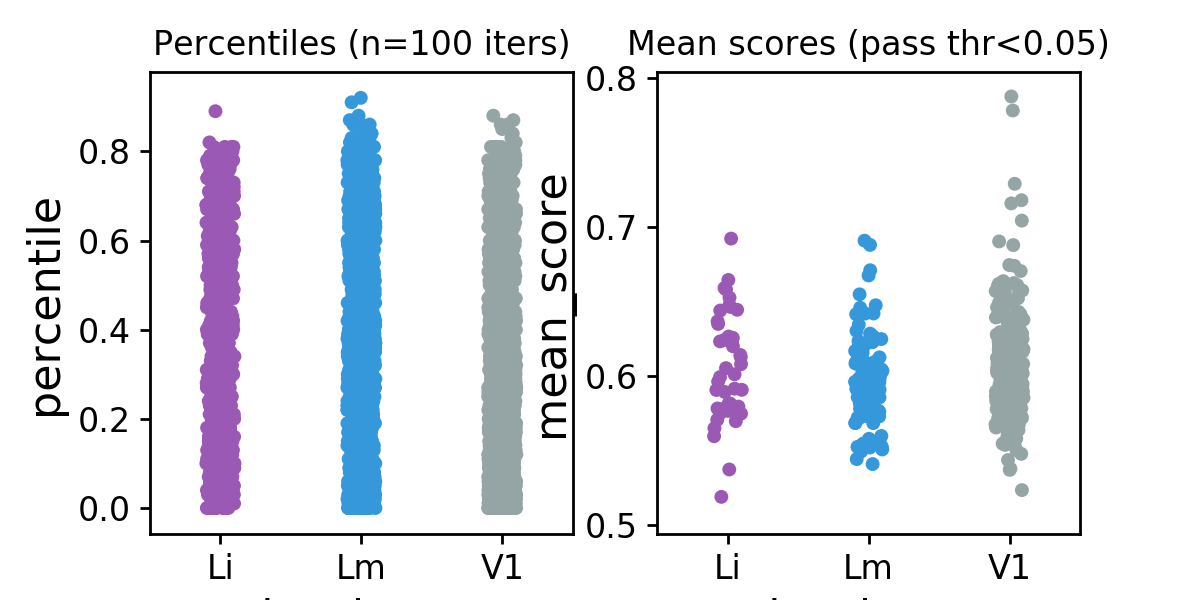

In [91]:
print(pass_perc.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']])

fig, axn = pl.subplots(1,2, figsize=(6, 3))

ax=axn[0]
ax.set_title('Percentiles (n=%i iters)' % n_iterations)
sns.stripplot(x='visual_area', y='percentile', data=scores_by_cell, ax=ax)

ax=axn[1]
ax.set_title('Mean scores (pass thr<%.2f)' % p_thr) # % n_iterations)
sns.stripplot(x='visual_area', y='mean_score', data=pass_perc, ax=ax)



In [64]:
del df

In [92]:
scores_by_cell.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]

,visual_area,cell
0,Li,562
1,Lm,1105
2,V1,1251


In [93]:
min_ncells=0
curr_dkeys = counts_by_fov[counts_by_fov['cell']>=min_ncells]['datakey'].unique()
all_dkeys = counts_by_fov['datakey'].unique()
print("%i of %i dkeys pass (min_ncells=%i)" % (len(curr_dkeys), len(all_dkeys), min_ncells))

42 of 42 dkeys pass (min_ncells=0)


<IPython.core.display.Javascript object>


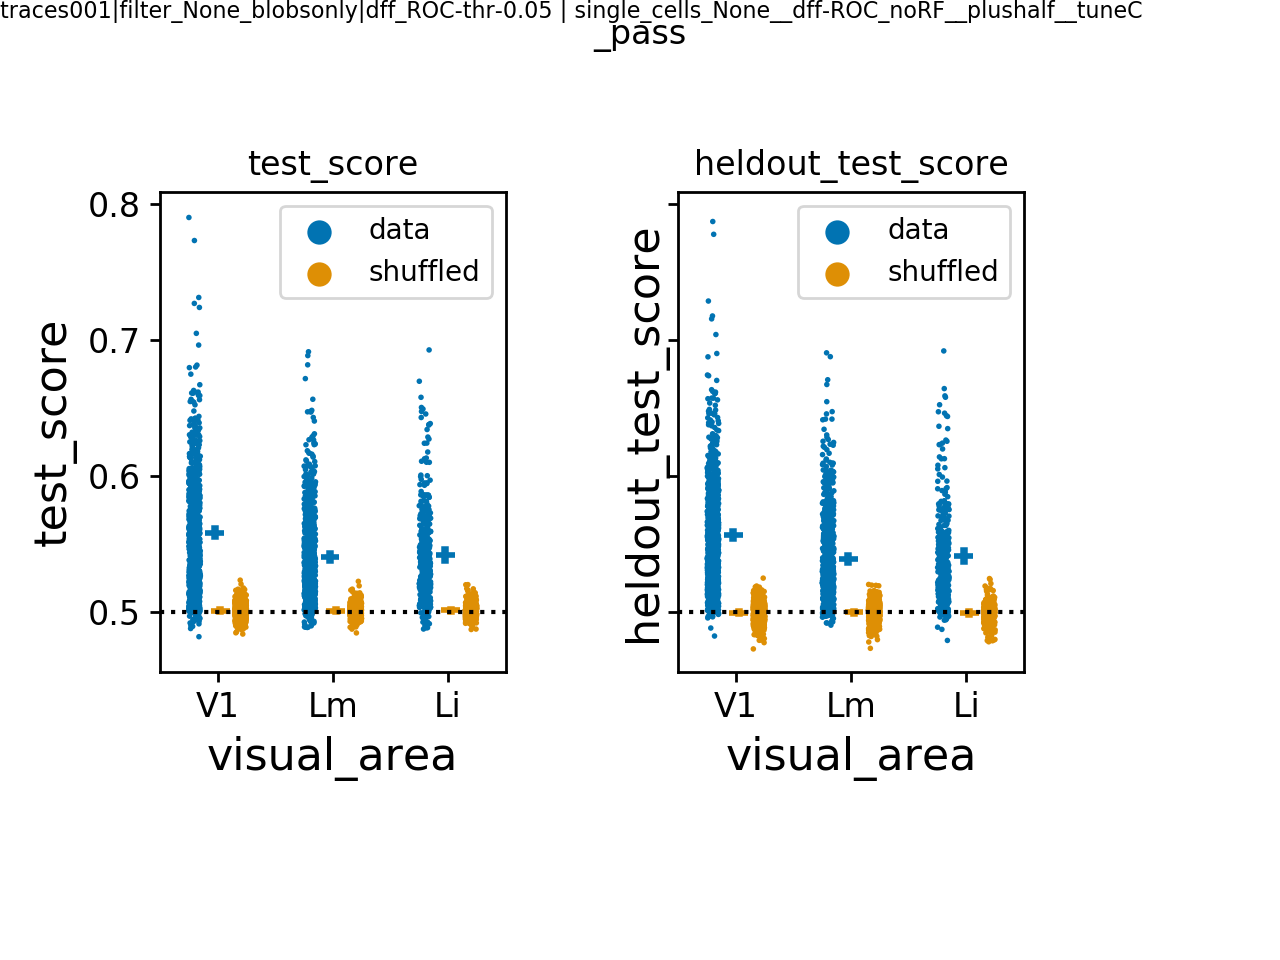

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_data-v-shuffled__pass')


In [94]:
xdf = passdf[(passdf['datakey'].isin(curr_dkeys))]# & ~(df['datakey'].isin(ign))]
#meandf = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

fig, axn = pl.subplots(1, 2, sharey=True)
ax=axn[0]
metric='test_score'
ax.set_title(metric)
sns.stripplot(x='visual_area',  y=metric, data=xdf, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=xdf, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


ax=axn[1]
metric='heldout_test_score'
ax.set_title(metric)
sns.stripplot(x='visual_area',  y=metric, data=xdf, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=xdf, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
pl.suptitle(pass_str)


figname = 'test_score__%s_data-v-shuffled_%s' % ( responsive_test, pass_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [87]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [40]:
xdf['visual_area'].unique()

array([u'Li', u'Lm', u'V1'], dtype=object)

In [41]:
area_colors

{'Li': 'orchid', 'Lm': 'cornflowerblue', 'V1': 'turquoise'}

In [42]:
passdf['visual_area'].unique()

array([u'Li', u'Lm', u'V1'], dtype=object)

<IPython.core.display.Javascript object>


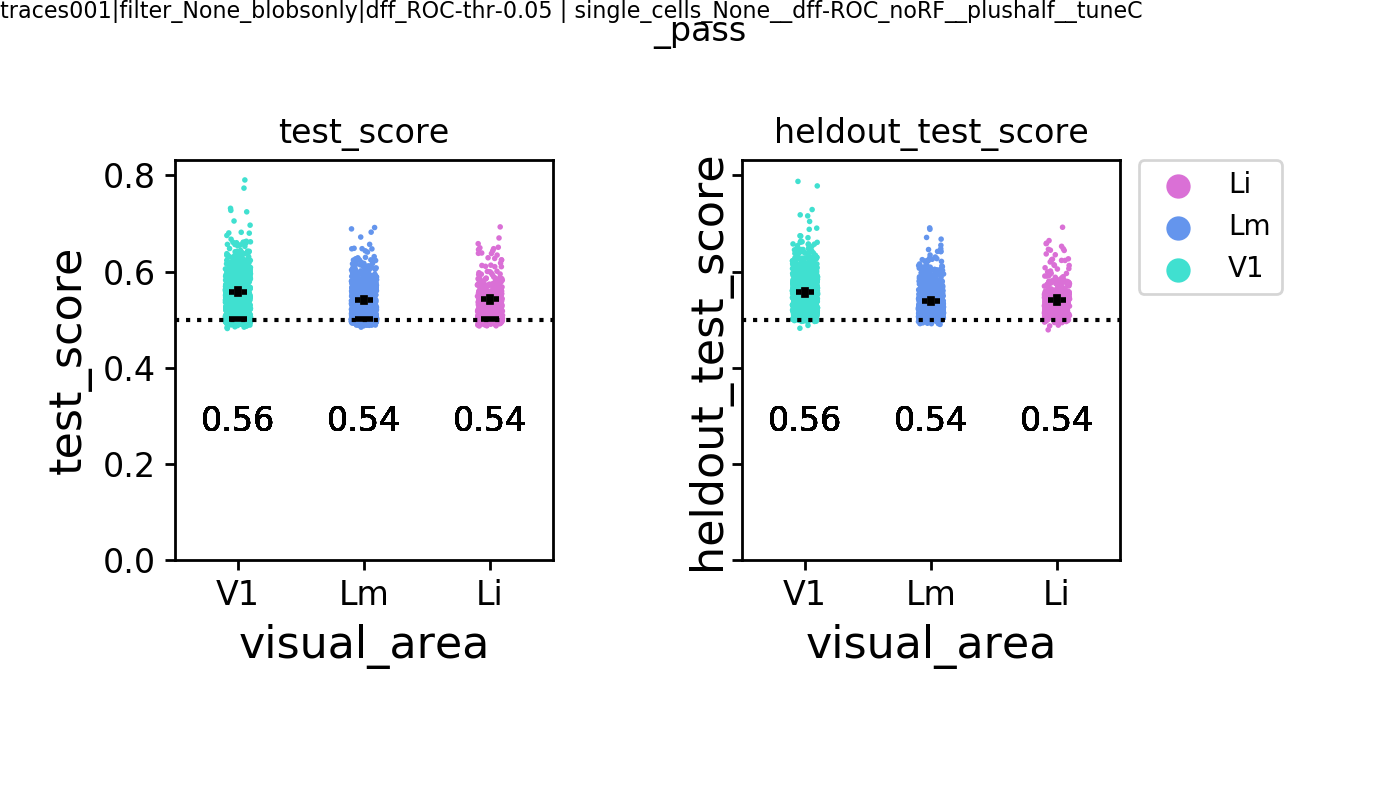

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_by_fov__pass')


In [95]:
curr_metric = 'test_score'
xdf = passdf[(passdf['datakey'].isin(curr_dkeys))]# & ~(singledf['datakey'].isin(ign))]

fig, axn = pl.subplots(1, 2, sharey=True, figsize=(7,4))
ax=axn[0]
metric='test_score' #curr_metric
ax.set_title(metric)

ax = stripplot_by_area(metric, xdf[xdf['condition']=='data'], ax=ax, visual_areas=visual_areas, 
                       area_colors=area_colors, 
                       size=2, bar=True, annotate=True, xytext=(0,50))
ax = stripplot_by_area(metric, xdf[xdf['condition']=='shuffled'], ax=ax, visual_areas=visual_areas, 
                       area_colors=area_colors, 
                       size=2, bar=False, annotate=False)

#### Label
if 'test_score' in metric:
    #ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, color='k', ls=':')
ax.legend_.remove()


ax=axn[1]
metric='heldout_%s' % curr_metric
ax.set_title(metric)
ax = stripplot_by_area(metric, xdf[xdf['condition']=='data'], ax=ax, visual_areas=visual_areas, 
                       area_colors=area_colors, size=2, bar=True, annotate=True, xytext=(0,50))

#ax.legend(bbox_to_anchor=(1.2, 1))
if 'test_score' in metric:
    #ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, color='k', ls=':')

aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1.2, 1))

putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
pl.suptitle(pass_str)

figname = 'test_score__%s_by_fov_%s' % (responsive_test, pass_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

#### Compare scores by FOV

In [105]:
excl = ['20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190314_JC070_fov1',
        '20190327_JC073_fov1', '20191018_JC113_fov1', '20191111_JC120_fov1', '20190327_JC073_fov1']
for x in sorted(excl):
    print(x)

20190314_JC070_fov1
20190319_JC067_fov1
20190320_JC067_fov1
20190321_JC070_fov1
20190327_JC073_fov1
20190327_JC073_fov1
20191018_JC113_fov1
20191111_JC120_fov1


In [106]:
# excl=[]
counts_by_fov = xdf[xdf['condition']=='data'].groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
min_ncells=0
counts_by_fov[counts_by_fov['cell']<min_ncells]

,visual_area,datakey,cell


V1    16
Lm    14
Li    11
Name: visual_area, dtype: int64


<IPython.core.display.Javascript object>


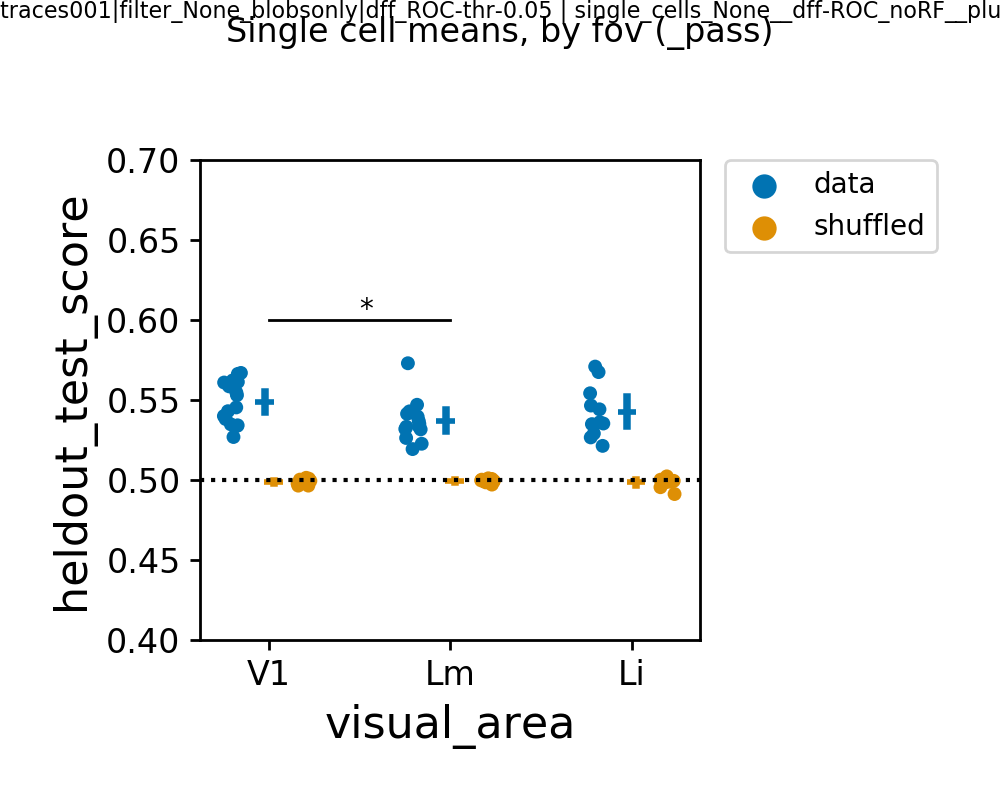

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.023 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.198 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.198 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_by_fov__pass')


In [107]:
metric = 'heldout_test_score'
#metric = 'test_score'
multi_comp_test='fdr_bh'


means_by_fov = xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
df_ = means_by_fov[~means_by_fov['datakey'].isin(excl)]

print(df_[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts())
      
fig, ax = pl.subplots( sharey=True, figsize=(5,4))
sns.stripplot(x='visual_area',  y=metric, data=df_, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=5, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=df_, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


#### Stats
statsresults, ax = aggr.plot_mannwhitney(df_[df_['condition']=='data'], 
                            metric=metric, multi_comp_test=multi_comp_test, 
                            ax=ax, y_loc=0.6, offset=0.01)
ax.set_ylim([0.4, 0.7])
aggr.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1.2, 1))


putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
pl.suptitle('Single cell means, by fov (%s)' % pass_str)
pl.subplots_adjust(left=0.2, top=0.8, bottom=0.2, right=0.7)


figname = 'test_score__%s_by_fov_%s' % (responsive_test, pass_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [357]:
means_by_fov[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts() #count()

V1    9
Lm    3
Li    2
Name: visual_area, dtype: int64

In [358]:

means_by_fov.groupby(['condition', 'visual_area']).mean()

cell          C  fit_time  heldout_MI  \
condition visual_area                                                
data      Li           108.611111  10.981620  0.001288    0.043220   
          Lm           120.428571   7.441943  0.001213    0.043400   
          V1           133.727778  11.247261  0.001581    0.053861   
shuffled  Li           108.611111  13.409375  0.001239    0.015167   
          Lm           120.428571  12.583047  0.001198    0.022144   
          V1           133.727778  13.210597  0.001731    0.031960   

                       heldout_aMI  heldout_log2MI  heldout_test_score  \
condition visual_area                                                    
data      Li              0.050405        0.062353            0.626212   
          Lm              0.050702        0.062612            0.623828   
          V1              0.066405        0.077706            0.633500   
shuffled  Li              0.008830        0.021881            0.495928   
          Lm              0.019021        0.031947            0.500201   
          V1              0.034477        0.046108            0.497006   

                       iteration  n_cells    n_trials       randi  score_time  \
condition visual_area                                                           
data      Li                49.5      1.0  295.000000  5174.49000    0.000366   
          Lm                49.5      1.0  296.666667  4743.19000    0.000388   
          V1                49.5      1.0  307.777778  5030.01654    0.000442   
shuffled  Li                49.5      1.0  295.000000  5174.49000    0.000355   
          Lm                49.5      1.0  296.666667  4743.19000    0.000396   
          V1                49.5      1.0  307.777778  5030.01654    0.000410   

                       test_score  train_score  
condition visual_area                           
data      Li             0.628061     0.628872  
          Lm             0.629172     0.632074  
          V1             0.635694     0.637317  
shuffled  Li             0.501999     0.518920  
          Lm             0.499955     0.517987  
          V1             0.499186     0.516976

In [359]:
groupdf[groupdf['visual_area']=='Li']['datakey'].unique()

array(['20190602_JC091_fov1', '20190607_JC091_fov1',
       '20190609_JC099_fov1', '20190612_JC099_fov1',
       '20191018_JC113_fov1'], dtype=object)

In [360]:
means_by_fov[means_by_fov['visual_area']=='Li']['datakey'].unique()

array(['20190602_JC091_fov1', '20190607_JC091_fov1'], dtype=object)

In [75]:
# fig, ax = pl.subplots()
# sns.barplot(x='visual_area', y=metric, data=xdf, 
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas, ax=ax)
# sns.swarmplot(x='visual_area', y=metric, data=xdf, ax=ax,
#              palette=area_colors,  order=visual_areas,)

# xdf.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -40))


<IPython.core.display.Javascript object>


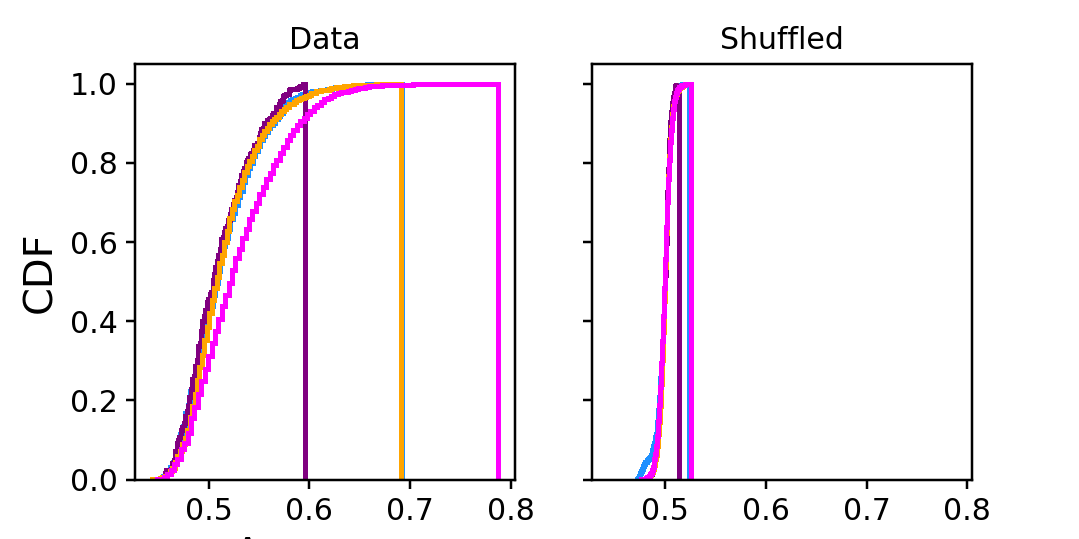

Text(0.5,1,u'Shuffled')

In [47]:
metric='heldout_test_score'
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)

ax=axn[0]
xdf = singledf.copy() #[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


for visual_area, vdf in means_by_cell[means_by_cell['condition']=='data'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
ax.set_title('Data')
ax.set_ylabel('CDF')
ax.set_xlabel('Accuracy')

ax=axn[1]
for visual_area, vdf in means_by_cell[means_by_cell['condition']=='shuffled'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True, lw=2, bins=100)
ax.set_title('Shuffled')

<IPython.core.display.Javascript object>


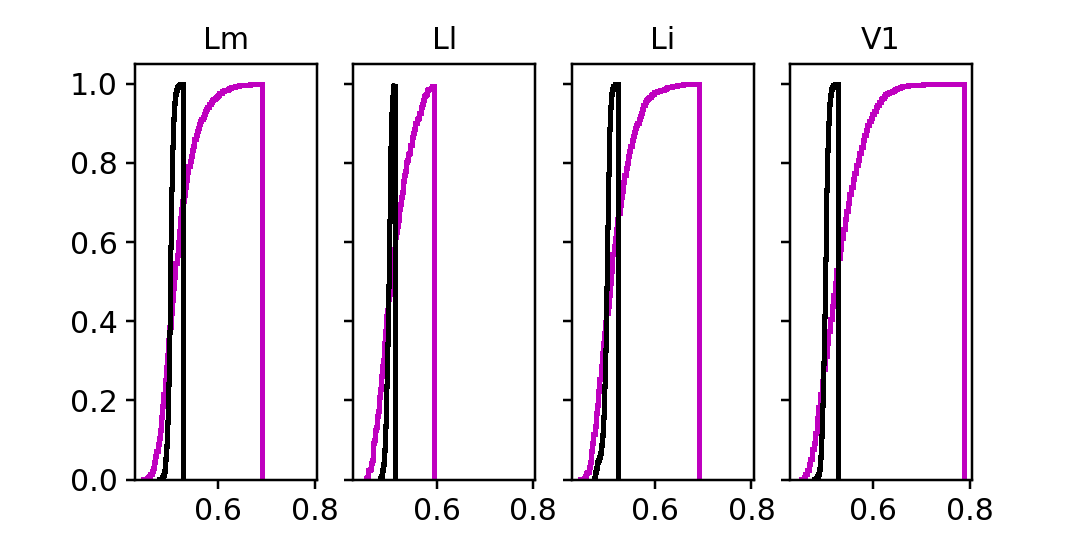

(u'Li', Ks_2sampResult(statistic=0.4716821639898563, pvalue=6.634645922201448e-116))
(u'Ll', Ks_2sampResult(statistic=0.4339080459770115, pvalue=1.948110918915034e-29))
(u'Lm', Ks_2sampResult(statistic=0.4589347934295669, pvalue=1.2588836229409475e-185))
(u'V1', Ks_2sampResult(statistic=0.5853458862054851, pvalue=0.0))


In [46]:
xdf = singledf.copy() #[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


fig, axn = pl.subplots(1,4, figsize=(6,3), sharex=True, sharey=True)
for ai, (visual_area, vdf) in enumerate(means_by_cell.groupby(['visual_area'])):
    ax=axn[2-ai]
    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    
    print("%s" % visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))
    
    n, bins, patches = ax.hist(d1[metric].values, color='m',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    n, bins, patches = ax.hist(d2[metric].values, color='k',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    
    ax.set_title(visual_area)
    

In [101]:
for visual_area in visual_areas:
    vdf = means_by_cell[means_by_cell['visual_area']==visual_area]

    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    

    print(visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))

('V1', Ks_2sampResult(statistic=0.6029106029106028, pvalue=1.3842212387758096e-306))
('Lm', Ks_2sampResult(statistic=0.451198129748685, pvalue=5.527543340959283e-153))
('Li', Ks_2sampResult(statistic=0.4696707105719238, pvalue=3.9504799758792587e-112))
('Ll', Ks_2sampResult(statistic=0.438953488372093, pvalue=8.887476305385559e-30))
